In [203]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim, linear_approx

$R_S >= \frac{1}{2\pi f_1C_S}$

$R_S = -\frac{V_{GS}}{I_{DS}}, R_G=100\text{kΩ}$

$f_1 = \frac{1}{2\pi C_CR_G} = 50\text{Hz}$

In [204]:
g_m = 1.37e-3
V_DS = 10
V_GS = 0.67
I_D = 5e-4
R_G = 100e3
f_1 = 50

In [205]:
R_S = V_GS/I_D
C_C = 1/(2*np.pi*f_1*R_G)
C_Smin = 1/(2*np.pi*f_1*R_S)
C_S = 10e-6
Z_S = 1/(1/R_S + 2*np.pi*f_1*C_S*1j)
print(f"{R_S=}, {C_C=}, {C_S=} >= {C_Smin}, {np.abs(Z_S/R_S)=}")

R_S=1340.0, C_C=3.183098861837907e-08, C_S=1e-05 >= 2.3754469118193335e-06, np.abs(Z_S/R_S)=0.23111359017851912


In [206]:
# 実測
C_S = 10.21e-6
C_C = 32.71e-9
R_L = 19.81e3
R_S = 988 + 297.6

In [207]:
data_d = pd.read_excel("data.xlsx", sheet_name="(4)(d)", skiprows=[1])
data_d.sort_values(by="v_i", axis=0, inplace=True, ascending=True)

In [208]:
data_3 = pd.read_excel("data.xlsx", sheet_name="(3)", skiprows=[0, 2], header=[0])
data_3.sort_values(by="V_GS", axis=0, inplace=True, ascending=True)

# (d)$v_i$ - $v_o$特性

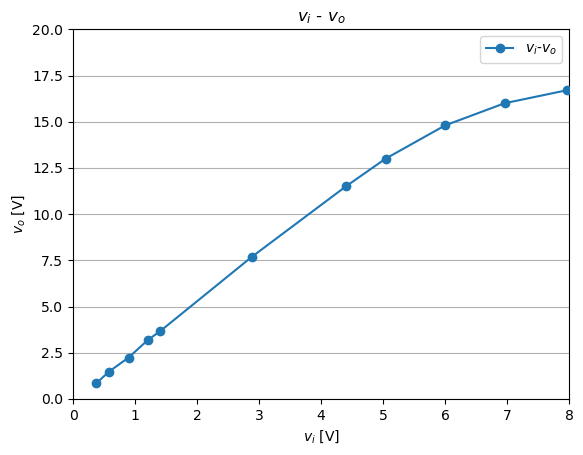

In [209]:
fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(legend=True, xlabel="$v_i$ [V]", grid="y", ylabel="$v_o$ [V]", title="$v_i$ - $v_o$", xlim=(0, 8), ylim=(0, 20))
ax.plot(data_d["v_i"], data_d["v_o"], marker="o", label="$v_i$-$v_o$", zorder=5)
# ax.plot(data_3["V_GS"], data_3["V_DS"], marker="o", label="$V_{GS}$-$V_{DS}$")
axessetting.apply_axes(ax)


# (e) 周波数特性

In [210]:
data_e = pd.read_excel("data.xlsx", sheet_name="(4)(e)", skiprows=[1])
data_e.sort_values(by="f", axis=0, inplace=True, ascending=True)
data_e["phase"] = -data_e["time"]* data_e["f"] * 360 * 1e-3
data_e["v_o"] *= 10

In [211]:
Av = lambda w, CD, Cgd, gm, RL, CC, RG: -(gm*RL-1j*w*RL*Cgd)/(1+1j*w*(Cgd+CD)*RL)*(1j*w*CC*RG)/(1+1j*w*CC*RG)
Av_abs = lambda f, CD, Cgd, gm, RL, CC, RG: np.abs(Av(2*np.pi*f, CD, Cgd, gm, RL, CC, RG))


In [230]:
# f2 = 5e4Hzからフィッティング
C_D = 1/(2*np.pi*5e4*20e3)
print(f"{C_D=}")
f1 = 1/(2*np.pi*C_C*R_G)
f2 = 1/(2*np.pi*C_D*R_L)
poptamp, pcov = curve_fit(lambda f, CD, Cgd, gm, RL, CC: 20*np.log10(Av_abs(f, CD, Cgd, gm, RL, CC, R_G)), data_e["f"], 20*np.log10(data_e["v_o"]/data_e["v_i"]), p0=[C_D, 2.6e-12, g_m, R_L, C_C], bounds=([0, 0, 0, 0, 0], [2*C_D, 5.2e-12, 2*g_m, 2*R_L, 2*C_C]))
print(poptamp)
poptphase, pcov = curve_fit(lambda f, CD, Cgd, gm, RL, CC: np.angle(Av(2*np.pi*f, CD, Cgd, gm, RL, CC, R_G), deg=True)%360.0, data_e["f"][:-1], data_e["phase"][:-1]%360.0, p0=[C_D, 2.6e-12, g_m, R_L, C_C], bounds=([0, 0, 0, 0, 0], [2*C_D, 5.2e-12, 2*g_m, 2*R_L, 2*C_C]))
print(poptphase)


C_D=1.5915494309189535e-10
[1.53661749e-10 2.15235243e-12 1.43783263e-03 1.84532071e+04
 2.16832169e-08]
[1.47649187e-10 1.42529669e-12 2.58787726e-03 2.16713520e+04
 1.67563844e-08]


(1.0, 50.0)

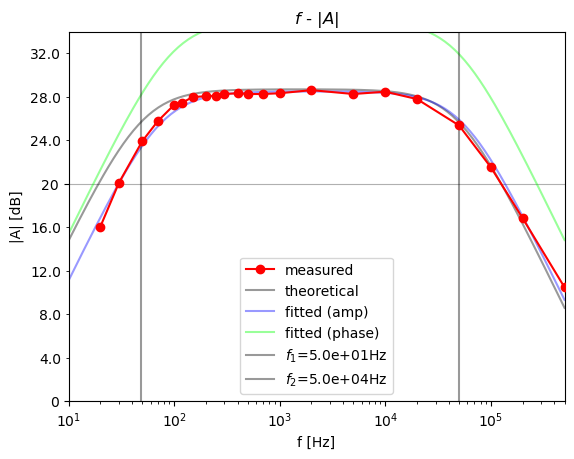

In [235]:
fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(legend=True, xlabel="f [Hz]", grid="y", ylabel="|A| [dB]", title="$f$ - $|A|$", xscale="log", yscale="log", xlim=(1e1, 5e5), ylim=(3, 30))
ax.plot(data_e["f"], data_e["v_o"]/data_e["v_i"], marker="o", color="red", label="measured", zorder=5)
axessetting.plot_func(ax, lambda f: Av_abs(f, C_D, 2.6e-12, g_m, R_L, C_C, R_G), label="theoretical", color="black", alpha=0.4)
axessetting.plot_func(ax, lambda f: Av_abs(f, *poptamp, R_G), label="fitted (amp)", color="blue", alpha=0.4)
axessetting.plot_func(ax, lambda f: Av_abs(f, *poptphase, R_G), label="fitted (phase)", color="lime", alpha=0.4)
ax.axvline(f1, color="black", alpha=0.4, label=f"$f_1$={f_1:.1e}Hz")
ax.axvline(f2, color="black", alpha=0.4, label=f"$f_2$={f2:.1e}Hz")
axessetting.apply_axes(ax)
ax.set_yticks(np.geomspace(1, 100, 3), labels=[0, 20, 40])
ax.set_yticks(np.geomspace(1, 100, 11), minor=True, labels=np.linspace(0, 40, 11))
ax.set_ylim(1, 50)
# ax.set_yticklabels(20*np.log10(ax.get_yticks()))


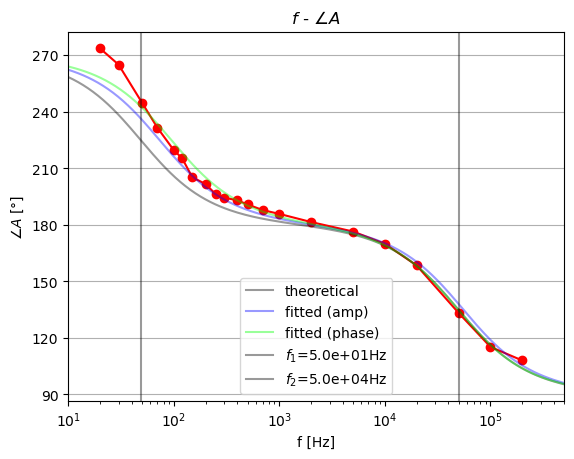

In [232]:

fig = plt.figure()
ax = fig.add_subplot(111)
axessetting = AxesSetting(legend=True, xlabel="f [Hz]", grid="y", ylabel="$\\angle A$ [°]", title="$f$ - $\\angle A$", xscale="log", xlim=(1e1,5e5))
ax.plot(data_e["f"][:-1], data_e["phase"][:-1]%360.0, marker="o", color="red")
axessetting.plot_func(ax, lambda f: np.angle(Av(2*np.pi*f, C_D, 2.6e-12, g_m, R_L, C_C, R_G), deg=True)%360.0, label="theoretical", color="black", alpha=0.4)
axessetting.plot_func(ax, lambda f: np.angle(Av(2*np.pi*f, *poptamp, R_G), deg=True)%360.0, label="fitted (amp)", color="blue", alpha=0.4)
axessetting.plot_func(ax, lambda f: np.angle(Av(2*np.pi*f, *poptphase, R_G), deg=True)%360.0, label="fitted (phase)", color="lime", alpha=0.4)
ax.axvline(f1, color="black", alpha=0.4, label=f"$f_1$={f_1:.1e}Hz")
ax.axvline(f2, color="black", alpha=0.4, label=f"$f_2$={f2:.1e}Hz")
axessetting.apply_axes(ax)
ax.set_yticks(np.linspace(90, 270, 7))


# (f)

In [237]:
# 1kHz
Vin = 2.42
Vout = 2.40
time=500e-6
print((g_m*R_L)/(1+g_m*R_S))
print(g_m*R_L)

9.828694891339932
27.139699999999998


# plot

In [216]:
df_osc = pd.read_csv("File0.csv", skiprows=[1])
df_osc

,X,CH1,CH2,Unnamed: 3
0,-0.001208,-3.32,17.0,NaN
1,-0.001204,-3.24,17.0,NaN
2,-0.001200,-3.24,17.0,NaN
3,-0.001196,-3.20,16.8,NaN
4,-0.001192,-3.16,16.8,NaN
...,...,...,...,...
595,0.001172,3.28,1.6,NaN
596,0.001176,3.28,1.8,NaN
597,0.001180,3.36,1.6,NaN
598,0.001184,3.32,1.6,NaN


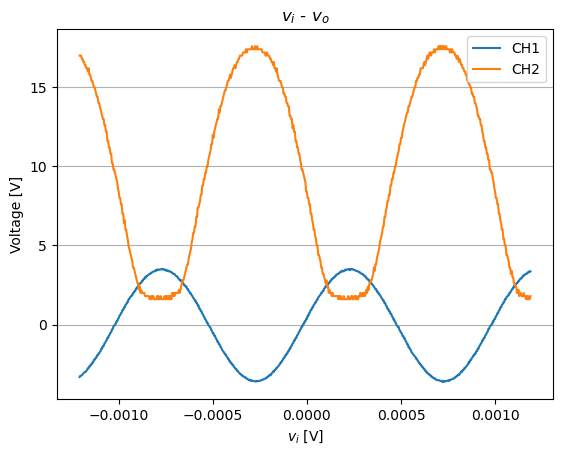

In [217]:
fig = plt.figure()
ax = fig.add_subplot(111)

axessetting = AxesSetting(legend=True, xlabel="$v_i$ [V]", grid="y", ylabel="Voltage [V]", title="$v_i$ - $v_o$")
ax.plot(df_osc["X"], df_osc["CH1"], label="CH1", zorder=5)
ax.plot(df_osc["X"], df_osc["CH2"], label="CH2", zorder=5)
axessetting.apply_axes(ax)
